# Clustering Islington Wards
## Data sources:
+ average age per wards as of 2011: http://www.ukcensusdata.com/islington-e09000019#sthash.GmfeNVqd.dpbs
+ yearly average income per wards as of 2011: https://data.london.gov.uk/dataset/household-income-estimates-small-areas
+ weekly average income per wards as of 2011 (not used):
https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/smallareaincomeestimatesformiddlelayersuperoutputareasenglandandwales
+ old to new wards code mapping: http://geoportal.statistics.gov.uk/datasets/65544c20a5804677a2594fe750bf4482_0
+ london wards geo boudaries: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

## Library imports:

In [149]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, export_png
from bokeh.models import GeoJSONDataSource, HoverTool, LogColorMapper, CategoricalColorMapper, LinearColorMapper, ColorBar, BasicTicker, PrintfTickFormatter
from bokeh.plotting import figure, show
from bokeh.palettes import Category20c, viridis, Viridis256, RdYlBu, RdBu, Spectral
import os
import imageio
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
output_notebook()

Loading BokehJS ...

## Load data:

### Load average age and income data:

In [26]:
data = pd.read_excel('./datasets/islington_census_2011.xlsx')

In [27]:
data

,ward_name,avg_age,avg_yearly_income,gss_code
0,Barnsbury,35.007622,41950,E05000366
1,Bunhill,33.014072,36620,E05000367
2,Caledonian,34.258348,33450,E05000368
3,Canonbury,35.139579,37860,E05000369
4,Clerkenwell,34.849521,40470,E05000370
5,Finsbury Park,33.539142,31750,E05000371
6,Highbury East,35.503094,44650,E05000372
7,Highbury West,33.402595,40780,E05000373
8,Hillrise,34.984144,36370,E05000374
9,Holloway,33.475873,32960,E05000375


### Load geo data for Islington wards:

In [38]:
wards = gpd.read_file('./datasets/london wards/London_Ward.shp')
wards = wards.rename(columns={'NAME': 'name', 'GSS_CODE': 'gss_code'})

In [39]:
wards.head()

,name,gss_code,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((517829.6 165447.1, 517837.1 165469.4..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((518107.5 167303.4, 518114.3 167307.5..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((520480 166909.8, 520490.7 166901.9, ..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((522071 168144.9, 522063.9 168144, 52..."


In [154]:
islington_wards = wards.loc[wards.BOROUGH=='Islington']
islington_wards.head()

,name,gss_code,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
533,Clerkenwell,E05000370,93.263,0.0,E09000019,Islington,50755,"POLYGON ((530916.9 182418.9, 530951.8 182460.1..."
534,Caledonian,E05000368,113.611,0.0,E09000019,Islington,50626,"POLYGON ((530021.3 184570.7, 530104.9 184611.8..."
535,St. Mary's,E05000379,86.831,0.0,E09000019,Islington,50761,"POLYGON ((531466 183278.7, 531426.4 183325.9, ..."
536,Holloway,E05000375,100.874,0.0,E09000019,Islington,117408,"POLYGON ((530021.3 184570.7, 530018.6 184584.8..."
537,Highbury East,E05000372,100.809,0.0,E09000019,Islington,50667,"POLYGON ((532488.1 185676.3, 532463.6 185676.3..."


## Visualization:

### View Islington wards:

### Method 1: dataframe.plot

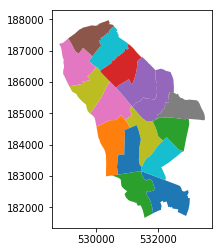

In [41]:
%matplotlib inline
islington_wards.plot(column='name', categorical=True)

### Scatter plot average age vs average income:

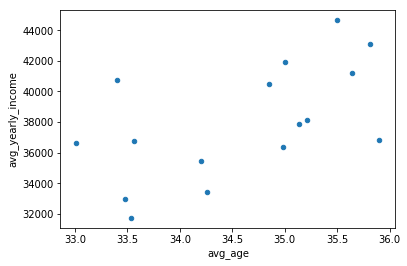

In [42]:
data.plot.scatter(x='avg_age', y='avg_yearly_income')

## Apply K-Means clustering:

In [44]:
data.head()

,ward_name,avg_age,avg_yearly_income,gss_code
0,Barnsbury,35.007622,41950,E05000366
1,Bunhill,33.014072,36620,E05000367
2,Caledonian,34.258348,33450,E05000368
3,Canonbury,35.139579,37860,E05000369
4,Clerkenwell,34.849521,40470,E05000370


In [51]:
x_train = data[['avg_age', 'avg_yearly_income']].values
x_train

array([[3.50076223e+01, 4.19500000e+04],
       [3.30140720e+01, 3.66200000e+04],
       [3.42583477e+01, 3.34500000e+04],
       [3.51395792e+01, 3.78600000e+04],
       [3.48495213e+01, 4.04700000e+04],
       [3.35391419e+01, 3.17500000e+04],
       [3.55030944e+01, 4.46500000e+04],
       [3.34025948e+01, 4.07800000e+04],
       [3.49841445e+01, 3.63700000e+04],
       [3.34758727e+01, 3.29600000e+04],
       [3.59030353e+01, 3.68500000e+04],
       [3.35624371e+01, 3.67800000e+04],
       [3.52089516e+01, 3.81700000e+04],
       [3.58118238e+01, 4.30700000e+04],
       [3.56458298e+01, 4.12100000e+04],
       [3.42040418e+01, 3.54900000e+04]])

In [97]:
model = KMeans(n_clusters=6)
model.fit(scale(x_train))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [98]:
data['cluster'] = model.labels_.astype(np.float64)
data

,ward_name,avg_age,avg_yearly_income,gss_code,cluster
0,Barnsbury,35.007622,41950,E05000366,5.0
1,Bunhill,33.014072,36620,E05000367,4.0
2,Caledonian,34.258348,33450,E05000368,0.0
3,Canonbury,35.139579,37860,E05000369,2.0
4,Clerkenwell,34.849521,40470,E05000370,5.0
5,Finsbury Park,33.539142,31750,E05000371,0.0
6,Highbury East,35.503094,44650,E05000372,1.0
7,Highbury West,33.402595,40780,E05000373,3.0
8,Hillrise,34.984144,36370,E05000374,2.0
9,Holloway,33.475873,32960,E05000375,0.0


In [99]:
model.labels_

array([5, 4, 0, 2, 5, 0, 1, 3, 2, 0, 2, 4, 2, 1, 1, 0])

## Visualize clusters:

### Method 1: dataframe.plot.scatter

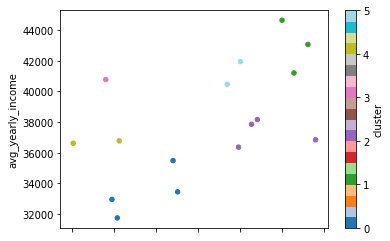

In [100]:
data.plot.scatter(x='avg_age', y='avg_yearly_income', c='cluster', marker='o', colormap='tab20')

### Method 2: matplotlib.pyplot

--- 0.0 ----
        ward_name    avg_age  avg_yearly_income   gss_code  cluster
2      Caledonian  34.258348              33450  E05000368      0.0
5   Finsbury Park  33.539142              31750  E05000371      0.0
9        Holloway  33.475873              32960  E05000375      0.0
15     Tollington  34.204042              35490  E05000381      0.0
--- 1.0 ----
        ward_name    avg_age  avg_yearly_income   gss_code  cluster
6   Highbury East  35.503094              44650  E05000372      1.0
13      St Mary's  35.811824              43070  E05000379      1.0
14     St Peter's  35.645830              41210  E05000380      1.0
--- 2.0 ----
      ward_name    avg_age  avg_yearly_income   gss_code  cluster
3     Canonbury  35.139579              37860  E05000369      2.0
8      Hillrise  34.984144              36370  E05000374      2.0
10     Junction  35.903035              36850  E05000376      2.0
12  St George's  35.208952              38170  E05000378      2.0
--- 3.0 ----
      

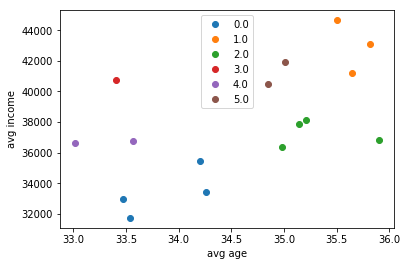

In [101]:
groups = data.groupby('cluster')

fig, ax = plt.subplots()
for name, group in groups:
    print('--- {} ----'.format(name))
    print(group)
    ax.plot(group.avg_age, group.avg_yearly_income, marker='o', linestyle='', label=name)
plt.xlabel('avg age')
plt.ylabel('avg income')
plt.legend()

### Method 3: bokeh

#### Merge cluster information with Islington wards geo data:

In [153]:
islington_wards_ext = islington_wards.merge(data, left_on='gss_code', right_on='gss_code')
islington_wards_ext['cluster'] = islington_wards_ext['cluster'].astype(str)
islington_wards_ext.sort_values(by='name').head()

,name,gss_code,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,ward_name,avg_age,avg_yearly_income,cluster
10,Barnsbury,E05000366,83.012,0.0,E09000019,Islington,50763,"POLYGON ((531095.6 184534.6, 531190.5 184574.6...",Barnsbury,35.007622,41950,5.0
7,Bunhill,E05000367,108.263,0.0,E09000019,Islington,50812,"POLYGON ((531450.3 183142.9, 531450.3 183151.8...",Bunhill,33.014072,36620,4.0
1,Caledonian,E05000368,113.611,0.0,E09000019,Islington,50626,"POLYGON ((530021.3 184570.7, 530104.9 184611.8...",Caledonian,34.258348,33450,0.0
9,Canonbury,E05000369,80.720,0.0,E09000019,Islington,117407,"POLYGON ((532148.1 184131.4, 532144.7 184134.1...",Canonbury,35.139579,37860,2.0
0,Clerkenwell,E05000370,93.263,0.0,E09000019,Islington,50755,"POLYGON ((530916.9 182418.9, 530951.8 182460.1...",Clerkenwell,34.849521,40470,5.0


#### Draw figure with Bokeh:

In [155]:
geo_source = GeoJSONDataSource(geojson=islington_wards_ext.to_json())

labels = islington_wards_ext.cluster.drop_duplicates()
color_mapper = CategoricalColorMapper(factors=labels.tolist(), palette=RdBu[len(labels.tolist())] )

fig = figure(title='Islington Wards Clustering by Avg Age & Avg Income', toolbar_location=None)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=geo_source,
            color={'field': 'cluster', 'transform': color_mapper}
         )

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips='<b>Ward</b>: @name<br/><b>Cluster</b>: @cluster<br/><b>Avg Age</b>: @avg_age<br/><b>Avg Income</b>: @avg_yearly_income<br/><b>GSS_CODE</b>: @gss_code'
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

# workaround to setup a legend as attribute legend doesn't work for patches!
for factor, color in zip(color_mapper.factors, color_mapper.palette):
    fig.circle(x=[], y=[], fill_color=color, legend=factor)
    
show(fig)

## Use Elbow test to decide on the number of clusters:

Text(0.5, 1.0, 'Elbow Curve Analysis')

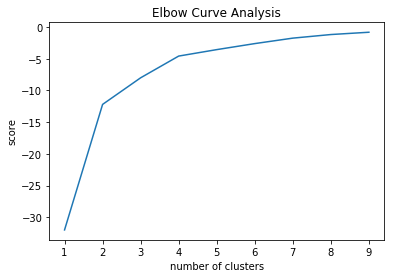

In [96]:
x = data['avg_age'].values
y = data['avg_yearly_income'].values
x_train_scale = scale(x_train)

n_clusters = np.arange(1, 10)
kmeans = [KMeans(n_clusters=n) for n in n_clusters]
score = [kmeans[n-1].fit(x_train_scale).score(x_train_scale) for n in n_clusters]

plt.plot(n_clusters, score)
plt.xlabel('number of clusters')
plt.ylabel('score')
plt.title('Elbow Curve Analysis')

#### Looking at the Elbow Curve Analysis, for our problem, 6 clusters seems optimal.